In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
from tqdm import tqdm

from mpmath import fp

#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


False
Random Seed:  999


In [2]:
from scipy.special import gamma,zeta,jv,jn_zeros,kv
from scipy.interpolate import griddata,RegularGridInterpolator,CubicSpline

import qcdlib.params as params
import qcdlib.cfg as cfg
from qcdlib.alphaS  import ALPHAS
from qcdlib.alphaS_dev  import ALPHAS as ALPHAS_DEV
from qcdlib.eweak   import EWEAK
from qcdlib.mellin import MELLIN
import qcdlib.special as special

from qcf.qcd_qcf_1d import PDF
from qcf.qcd_ff_1d import FF_PIP

In [3]:
mellin = MELLIN()
alphaS = ALPHAS()
pdf = PDF(mellin,alphaS)
ff = FF_PIP(mellin,alphaS)

In [4]:
X = 10**np.linspace(-4,0,100)
Q2 = 10.0

uv = []
dv = []
g = []
for x in X:
    uv.append(pdf.get_xF(x,Q2,'uv'))
    dv.append(pdf.get_xF(x,Q2,'dv'))
    g.append(pdf.get_xF(x,Q2,'g'))
uv = np.array(uv)
dv = np.array(dv)
g = np.array(g)

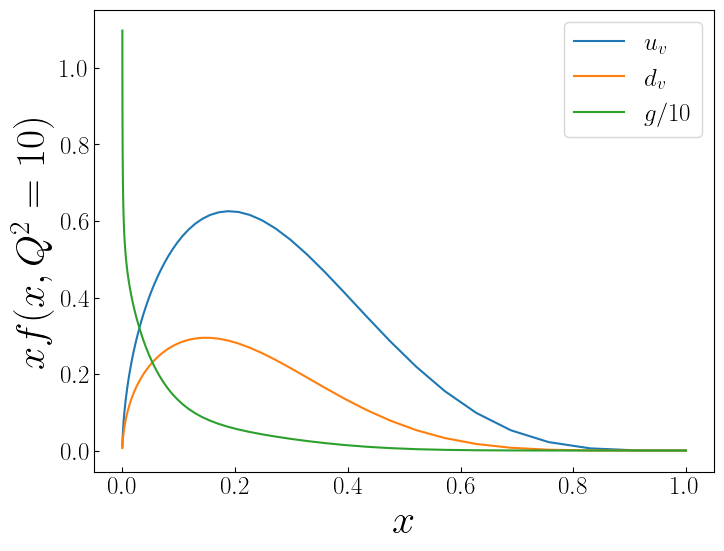

In [5]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

ax.plot(X,uv,label=r'$u_v$')
ax.plot(X,dv,label=r'$d_v$')
ax.plot(X,g/10,label=r'$g/10$')
ax.legend(fontsize=18)
# ax.semilogx()
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2=10)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')


In [6]:
class MODEL:
    
    def __init__(self):
        #--params
        euler=special.euler

        self.Q0 = np.sqrt(cfg.Q20)
        self.C1=2*np.exp(-euler)
        self.C2=1
        
        self.bmax = self.C1/self.Q0 #--so that mub > mu_0
    
    #============================================================
    #--Defining functions associated with bstar
    #============================================================
    #--typical logarithm in perturbative expansions
    def get_Log(self,bT,mu):  
        """
        Typical log in the expansion
        """
        return np.log(mu*bT/self.C1)

    #--Setting up b_*
    def get_bstar(self,bT):
        """
        Returns b*
        """
        return bT/np.sqrt(1+bT**2/self.bmax**2)

    def get_mub(self,bT): 
        """
        Returns mub* 
        """
        return self.C1/self.get_bstar(bT)


In [7]:
tmdmodel = MODEL()

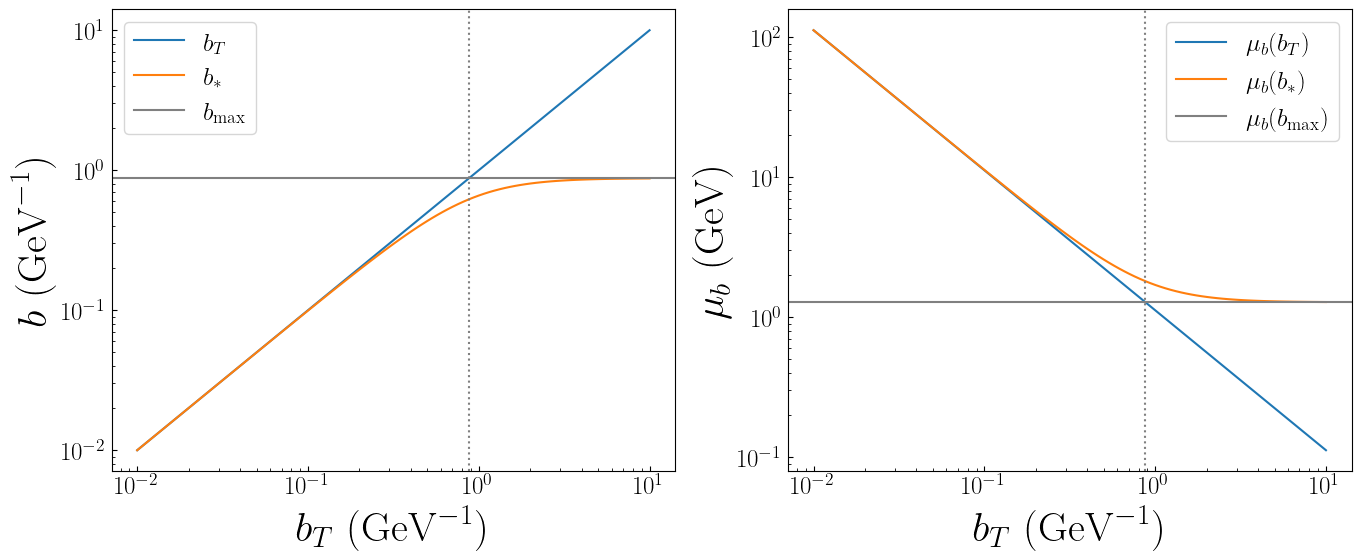

In [8]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

bT = 10**np.linspace(-2,1,100)

bstar = tmdmodel.get_bstar(bT)

mubstar = tmdmodel.get_mub(bT)
mu_nobstar = tmdmodel.C1 / bT

ax=py.subplot(nrows,ncols,1)
ax.plot(bT,bT,label=r'$b_T$')
ax.plot(bT,bstar,label=r'$b_*$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y=tmdmodel.bmax,c='grey',label=r'$b_{\rm max}$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$b~({\rm GeV}^{-1})$',size=30)
ax.loglog()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)

ax=py.subplot(nrows,ncols,2)
ax.plot(bT,mu_nobstar,label=r'$\mu_b(b_T)$')
ax.plot(bT,mubstar,label=r'$\mu_b(b_*)$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y= tmdmodel.C1 / tmdmodel.bmax,ls='-',c='grey',label=r'$\mu_b(b_{\rm max})$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
ax.semilogx()
ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$\mu_b~({\rm GeV})$',size=30)
ax.legend(fontsize=18)


In [9]:
class PDF_OPE:
    
    def __init__(self,pdf):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.pdf = pdf
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        
        self.NLOq1= -1/N - 1/(N+1) - 2*special.euler - 2*psi0N # M transform of Pqq=(2/(1-x)_{+} -1-x)
        self.NLOq2=  1/N - 1/(N+1) # M transform of (1-x)

        self.NLOg1= 1/N - 2/(N+1) + 2/(N+2)  # M transform of Pgq=1-2x(1-x)
        self.NLOg2= 1/(N+1)-1/(N+2)  # M tranform of x(1-x) 

        
    def get_OPE_TMDPDF(self,x,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        x: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(x,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.pdf.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.pdf.evolve(mub**2)
            
            moments=self.pdf.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+2*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.TF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            xspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                xspace_convolutions[+i]=self.mellin.invert(x,mellin_convolutions[+i])
                xspace_convolutions[-i]=self.mellin.invert(x,mellin_convolutions[-i])
            self.storage_ope[key]=xspace_convolutions

        return self.storage_ope[key]


In [10]:
class FF_OPE:
    
    def __init__(self,ff):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.ff = ff
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        psi1N = special.get_psi(1,N)

        """
        Please check my FF terms with Nanga Parbat!
        The pieces not proportional to Log are verified from Eq. 2.81 in JHEP06(2020)137 (SV19).
        """

        """
        quark pieces: Mellin transform of:
        alphaS * CF / 2 / pi * ( -2 * (Log - log(z)) * (2 / (1-z)_+  + 1 / z**2 + 1 / z) + 1 / z**2 - 1 / z
                                + delta(1-z) * ( -2 * Log**2 - 2 * Log * log(zeta/mu**2) - pi**2/6))
        """
        self.NLOq1= -2 * psi0N - 2 * special.euler + 1 / (N + 2) + 1 / (N + 1)
        self.NLOq2= -2 * psi1N - 1 / (N - 2)**2 - 1 / (N - 1)**2 + 1 / 2 / (N + 2) - 1 / 2 / (N + 1)

        """
        gluon pieces: Mellin transform of:
        alphaS * CF / 2 / pi / z**3 * ( -2 * (1 + (1-z)**2) * (Log - log(z)) + z**2) 
        """
        self.NLOg1= 2 / (N - 3) + 1 / (N - 1) - 2 / (N - 2) 
        self.NLOg2= -2 / (N - 3)**2 - 2 / (N - 1)**2 + 2 / (N - 2) + 1 / 2 / (N - 1)
        
    def get_OPE_TMDFF(self,z,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        z: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(z,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.ff.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.ff.evolve(mub**2)
            
            moments=self.ff.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+4*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.CF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            zspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                zspace_convolutions[+i]=self.mellin.invert(z,mellin_convolutions[+i])
                zspace_convolutions[-i]=self.mellin.invert(z,mellin_convolutions[-i])
            self.storage_ope[key]=zspace_convolutions

        return self.storage_ope[key]


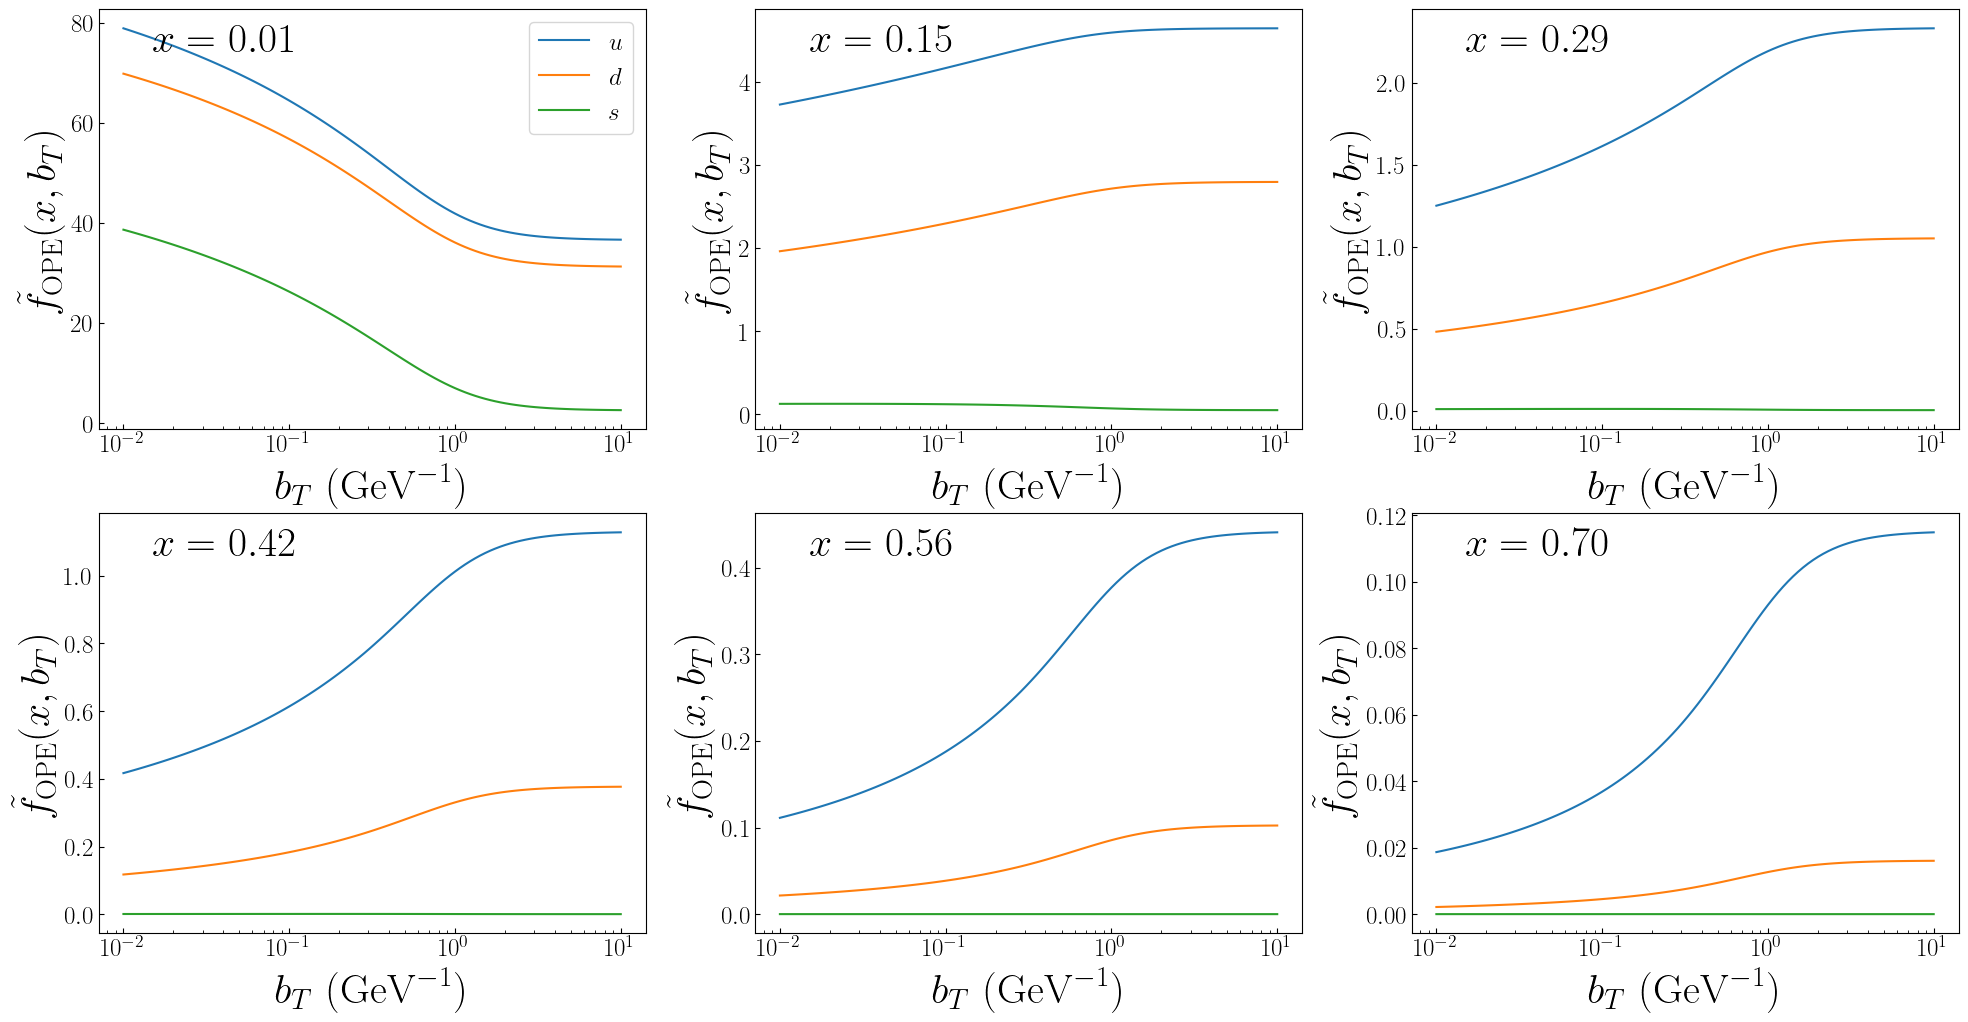

In [11]:
Xs = np.linspace(0.01,0.7,6)
bTs = 10**np.linspace(-2,1,100)

ope = PDF_OPE(pdf)

nrows,ncols=2,3
py.figure(figsize=(8*ncols,6*nrows))
cnt=0

flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$b$',r'$\bar{b}$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
for x in Xs:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)

    opes = np.zeros((11,len(bTs)))
    for i in range(len(bTs)):
        opetmd = ope.get_OPE_TMDPDF(x,bTs[i])
        for j in range(len(opes)):
            opes[j][i] = opetmd[j]

    for i in range(len(opes)):
        if i in [0,4,5,6,7,8,9,10]: continue
        ax.plot(bTs, opes[i],label=flav_lab[i])

    ax.semilogx()
    ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
    ax.set_ylabel(r'$\tilde{f}_{\rm OPE}(x,b_T)$',size=30)
    ax.text(0.1,0.9,r'$x=%.2f$'%x,transform=ax.transAxes,size=30)
    if cnt==1: ax.legend(fontsize=18)
    ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [12]:
class PERTURBATIVE_EVOLUTION:
    
    def __init__(self,alphaS,tmdmodel):

        self.iorder = cfg.tmd_resummation_order

        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        self.zeta2 = zeta(2)
        self.zeta3 = zeta(3)
        self.zeta4 = zeta(4)
        self.zeta5 = zeta(5)

        self.alphaS = alphaS
        self.tmdmodel=tmdmodel

        self.storage_Sudakov={}

    def reset_storage_Sudakov(self):
        self.storage_Sudakov={}


    #============================================================
    #--Setting up Gamma_cusp
    #============================================================
    """
    \$\Gamma\$-cusp

     notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

     Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
     - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
     """

    def get_Gamma0(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 4. * self.CF

    def get_Gamma1(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF * (self.CA * (67/9 - np.pi**2/3)\
                   - 20/9 * self.TR * Nf)

    def get_Gamma2(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF *(self.CA**2 * (245/6 - 134/27*np.pi**2 + 11/45*np.pi**4 + 22/3*self.zeta3) \
                    + self.CA * self.TR * Nf * (-418/27 + 40/27*np.pi**2 - 56/3*self.zeta3)\
                    + self.CF * self.TR * Nf * (-55/3 + 16 * self.zeta3) - 16/27 * self.TR**2 * Nf**2 )

    def get_Gamma3(self,mu):
        #--aS**4
        Nf=self.alphaS.get_Nf(mu**2)
        dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
        dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

        return  self.CF*( \
                dFA*(7040/3*self.zeta5 +256/3*self.zeta3-768*(self.zeta3**2) -256*self.zeta2 -15872/35*(self.zeta2**3))\
                +dFF*Nf*(-2560/3*self.zeta5 -512/3*self.zeta3 +512*self.zeta2)\
                +(Nf**3)*(-32/81 +64/27*self.zeta3)\
                +self.CF*(Nf**2)*(2392/81 -640/9*self.zeta3 +64/5*(self.zeta2**2))\
                +(self.CF**2)*Nf*(572/9 -320*self.zeta5 +592/3*self.zeta3)\
                +self.CA*(Nf**2)*(923/81 +2240/27*self.zeta3 -608/81*self.zeta2 -224/15*(self.zeta2**2))\
                +self.CF*self.CA*Nf*(-34066/81 +160*self.zeta5 +3712/9*self.zeta3 +440/3*self.zeta2 -128*self.zeta2*self.zeta3 -352/5*(self.zeta2**2))\
                +(self.CA**2)*Nf*(-24137/81 +2096/9*self.zeta5 -23104/27*self.zeta3 +20320/81*self.zeta2 \
                +448/3*self.zeta2*self.zeta3 -352/15*(self.zeta2**2))\
                +(self.CA**3)*(84278/81 - 3608/9*self.zeta5 +20944/27*self.zeta3 -16*(self.zeta3**2) \
                -88400/81*self.zeta2 -352/3*self.zeta2*self.zeta3 +3608/5*(self.zeta2**2)-20032/105*(self.zeta2**3)))     


    #============================================================
    #--Setting up gamma_J
    #============================================================
    """
    Here we calculate the \$\gamma_{J}\$ Eq. (58) of PhysRevD.96.054011
    """
    def get_gammaJ1(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 6. * self.CF

    def get_gammaJ2(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * (3. - 4. * np.pi**2 + 48. * self.zeta3)\
                        + self.CF * self.CA * (961./27. + 11. * np.pi**2/3. - 52. * self.zeta3)\
                        + self.CF * Nf * (-130./27. - 2. * np.pi**2/3.) 

    def get_gammaJ3(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * Nf * (-2953./27. + 26. * np.pi**2/9 + 28. * np.pi**4/27 - 512. * self.zeta3/9.)\
                        + self.CF * Nf**2 * (-4834./729. + 20. * np.pi**2/27. + 16. * self.zeta3/27. )\
                        + self.CF**3 * (29. + 6. * np.pi**2 + 16. * np.pi**4/5. + 136. * self.zeta3 - 32. * np.pi**2 * self.zeta3/3. - 480. * self.zeta5)\
                        + self.CA**2 * self.CF * (139345./1458. + 7163. * np.pi**2/243. + 83. * np.pi**4/45. - 7052. * self.zeta3/9. + 88. * np.pi**2 * self.zeta3/9. + 272. * self.zeta5 )\
                        + self.CA * self.CF * Nf * (17318./729. - 2594. * np.pi**2/243. - 22. * np.pi**4/45. + 1928. * self.zeta3/27.)\
                        + self.CA * self.CF**2 * (151./2. - 410. * np.pi**2/9. - 494. * np.pi**4/135. + 1688. * self.zeta3/3. + 16. * np.pi**2 * self.zeta3/3. + 240. * self.zeta5)


    #============================================================
    #--Setting up perturbative evolution
    #============================================================
    """
    Perturbative part of the evolution  (perturbative Sudakov and Collins-Soper kernel)

    for gamma3 we use Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D
    """

    def get_Ktilde(self,bT,mu):
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-np.pi**2/3)*self.CA - (20/9)*self.TR*Nf
        Gamma3 = self.CA**2*(245/6 - 134*np.pi**2/27 + 11*np.pi**4/45 + 22*self.zeta3/3) \
                        + self.CA*self.TR*Nf*(-418/27 + 40*np.pi**2/27 - 56*self.zeta3/3) \
                        + self.CF*self.TR*Nf*(-55/3 + 16*self.zeta3) - (16/27)*self.TR**2*Nf**2
        beta1 = (11/3)*self.CA - (4/3)*self.TR*Nf # 
        beta2 = 34*self.CA**2/3 - 20*self.CA*self.TR*Nf/3 - 4*self.CF*self.TR*Nf # 

        d20 = self.CA*(404/27 - 14*self.zeta3) - 112*self.TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-self.CA**2/2)*(-176*self.zeta3*self.zeta2/3 + 6392*self.zeta2/81 + 12328*self.zeta3/27 + 154*self.zeta4/3 - 192*self.zeta5 - 297029/729) \
                    - self.CA*self.TR*Nf*(-824*self.zeta2/81 - 904*self.zeta3/27 + 20*self.zeta4/3 + 62626/729) \
                    - 2*self.TR**2*Nf**2*(-32*self.zeta3/9 - 1856/729) \
                    - self.CF*self.TR*Nf*(-304*self.zeta3/9 - 16*self.zeta4 + 1711/27)
        ######################################

        Ktilde = 0

        if self.iorder>0: 

            Ktilde += -8 * self.CF * aS * log

        if self.iorder>1:

            Ktilde += 8 * self.CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * self.CA) * log**2 \
                        +  (-67/9 * self.CA + np.pi**2/3 * self.CA + 10/9 * Nf) * log \
                        +  (7/2 * self.zeta3 - 101/27) * self.CA + 14/27 * Nf )

        if self.iorder>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D

            Ktilde += -2*self.CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde


    def get_gammaF(self,mu):
        """
        Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gammaF = 0

        if self.iorder>0:
            GAMMA1 = self.get_gammaJ1(mu)
            gammaF += GAMMA1 * aS

        if self.iorder>1:
            GAMMA2 = self.get_gammaJ2(mu)           
            gammaF += aS**2 * GAMMA2

        if self.iorder>2:
            GAMMA3 = self.get_gammaJ3(mu)
            gammaF += aS**3 * GAMMA3

        return gammaF

    def get_gammaK(self,mu):
        """
        Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gamma0 = self.get_Gamma0(mu)        
        gammaK = 2 * gamma0 * aS

        if self.iorder>0: 
            gamma1 = self.get_Gamma1(mu)
            gammaK += aS**2 * 2 * gamma1

        if self.iorder>1:
            gamma2 = self.get_Gamma2(mu)
            gammaK += aS**3 * 2 * gamma2

        if self.iorder>2:
            gamma3 = self.get_Gamma3(mu)
            gammaK += aS**4 * 2 * gamma3

        return gammaK

    def get_integrand_gammas(self,mup,zeta):
        return 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup))


    def get_Sudakov_perturbative(self,muQ,zeta,bT):
        """
        perturbative part of the evolution in the solution 
        maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011 
        Returns perturbative Sudakov using b* and mub* 
        """
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        bstar = self.tmdmodel.get_bstar(bT) # returns b*

        key = (muQ,zeta,bstar)
        if key not in self.storage_Sudakov:
            integral_gammas=quad(lambda mup: self.get_integrand_gammas(mup,zeta),mub,muQ)[0]            
            self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + integral_gammas
        return self.storage_Sudakov[key] 

    def get_exp_Sudakov_perturbative(self,Q,bT):
        """
        Exponential of perturbative part of the evolution 
        in the solution maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011


        For the purposes of this code, I am assuming that zeta=Q**2 and that muQ = Q.
        This does not necessarily have to happen!
        """
        muQ = Q
        zeta = Q**2
        return np.exp(self.get_Sudakov_perturbative(muQ,zeta,bT)) 


In [13]:
pertevo = PERTURBATIVE_EVOLUTION(alphaS,tmdmodel)

In [14]:

bTs = 10**np.linspace(-2,2,100)
Q = np.linspace(3,10,50)

sud = np.zeros((len(bTs),len(Q)))
for i in range(len(bTs)):
    for j in range(len(Q)):
        # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
        sud[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i])
#sud=np.array(sud)


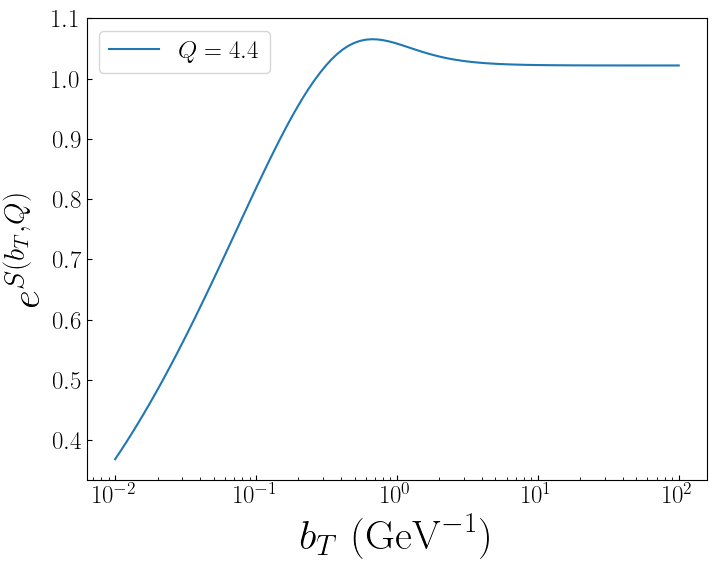

In [15]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

idx = 10
ax.plot(bTs,sud.T[idx],label=r'$Q=%.1f$'%Q[idx])
ax.semilogx()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

In [16]:
from tools.tools import interpolate

In [17]:
bTs = torch.tensor(bTs,dtype=torch.float64)
Q = torch.tensor(Q,dtype=torch.float64)
sud = torch.tensor(sud,dtype=torch.float64)

In [18]:
bTs_new = 10**torch.linspace(-1.8,1.8,200,dtype=torch.float64)
interped =  interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)

sud0 = sud.T[0]

sud_mod = torch.einsum('jb,b->j',interped,sud0)


In [19]:
# interped

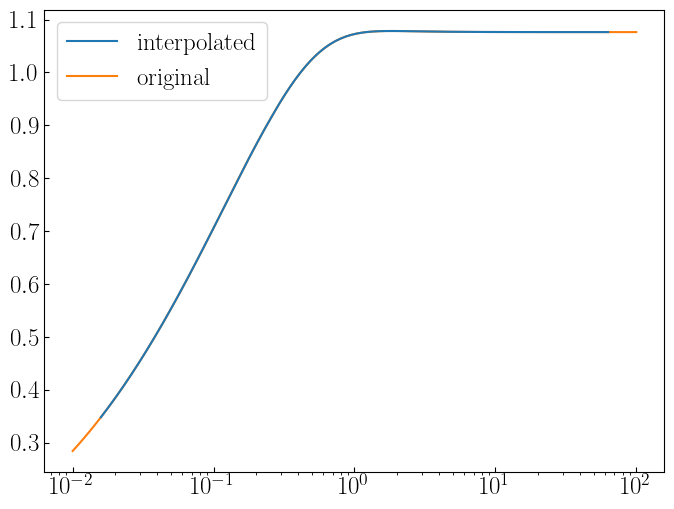

In [20]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

ax.plot(bTs_new,sud_mod,label=r'$\rm interpolated$',zorder=10)
ax.plot(bTs,sud0,label=r'$\rm original$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)

In [21]:
Q_new = torch.linspace(3,10,300,dtype=torch.float64)
bTs_new = 10**torch.linspace(-2,2,500,dtype=torch.float64)

In [22]:
interpbT = interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)
interpQ  = interpolate(Q,Q_new,'cubic-turbo',device,torch.float64)

In [23]:
print(interpbT.shape,interpQ.shape,sud.shape)

torch.Size([500, 100]) torch.Size([300, 50]) torch.Size([100, 50])


In [24]:
sud_new = torch.einsum('ib,bQ,jQ->ij',interpbT,sud,interpQ)

Text(0.4, 0.1, '$b_T=10.72~{\\rm GeV}^{-1}$')

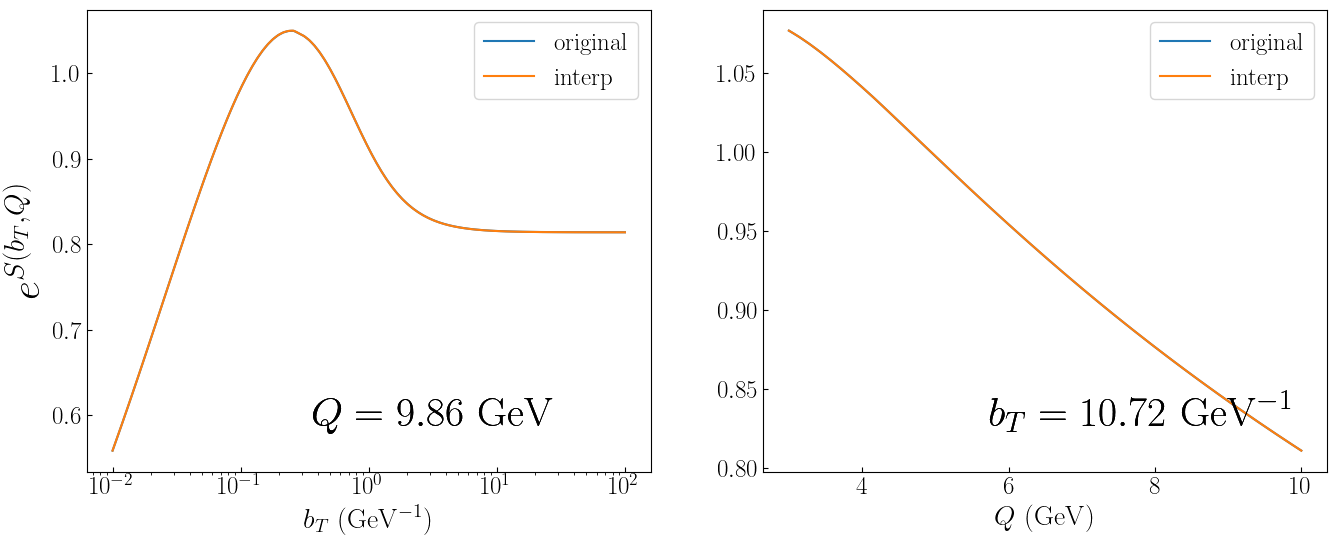

In [25]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

# ax.plot(x_new[x_new>1],sud_mod[x_new>1],label=r'$\rm interpolated$')
# ax.plot(x_old[x_old>1],sud0[x_old>1],label=r'$\rm original$')

idx=-2
ax.plot(bTs,sud.T[idx],label=r'\rm original')
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q[idx],transform=ax.transAxes,size=30)

idx = -7
ax.plot(bTs_new,sud_new.T[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=20)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q_new[idx],transform=ax.transAxes,size=30)

ax=py.subplot(nrows,ncols,2)

idx=75
ax.plot(Q,sud[idx],label=r'$\rm original$')
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs[idx],transform=ax.transAxes,size=30)
idx=378
ax.plot(Q_new,sud_new[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.legend(fontsize=18)
ax.set_xlabel(r'$Q~({\rm GeV})$',size=20)
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs_new[idx],transform=ax.transAxes,size=30)


# Integration over $b_T$

## First take the Hankel transform of a known function
## $\int_0^\infty db_T b_T J_0(b_T q_T) K_0(n b_T) = \frac{1}{(n^2 + k_T^2)}$

In [26]:
def integrand(bT,qT):
    func = kv(0,2*bT)
    return bT * jv(0,bT * qT) * func

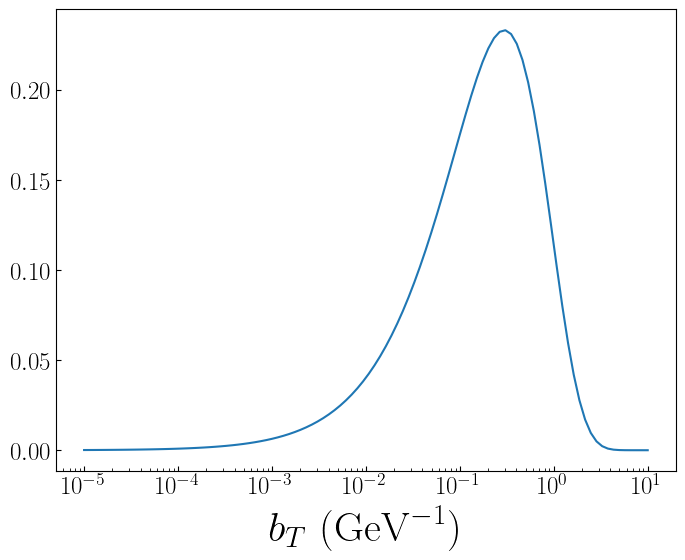

In [27]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,1,100)
qT = 0.0

intgd = integrand(bTs,qT)
ax.plot(bTs,intgd)
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [28]:
def analytic_func(qT):
    return 1 / (4 + qT**2)

In [29]:
def get_WZ(bTnodes,pT,precision=1e-6):

    quad_precision = precision

    bTmax =100

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand(bT,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand(bT,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand(bT,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand(bT,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand(bT,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [30]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,100)
bmax = 100

numeric=[]
for qt in qTs:
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,qt,1e-20))
numeric=np.array(numeric)

analytic = analytic_func(qTs)

In [31]:
rel_err = (numeric - analytic) / analytic

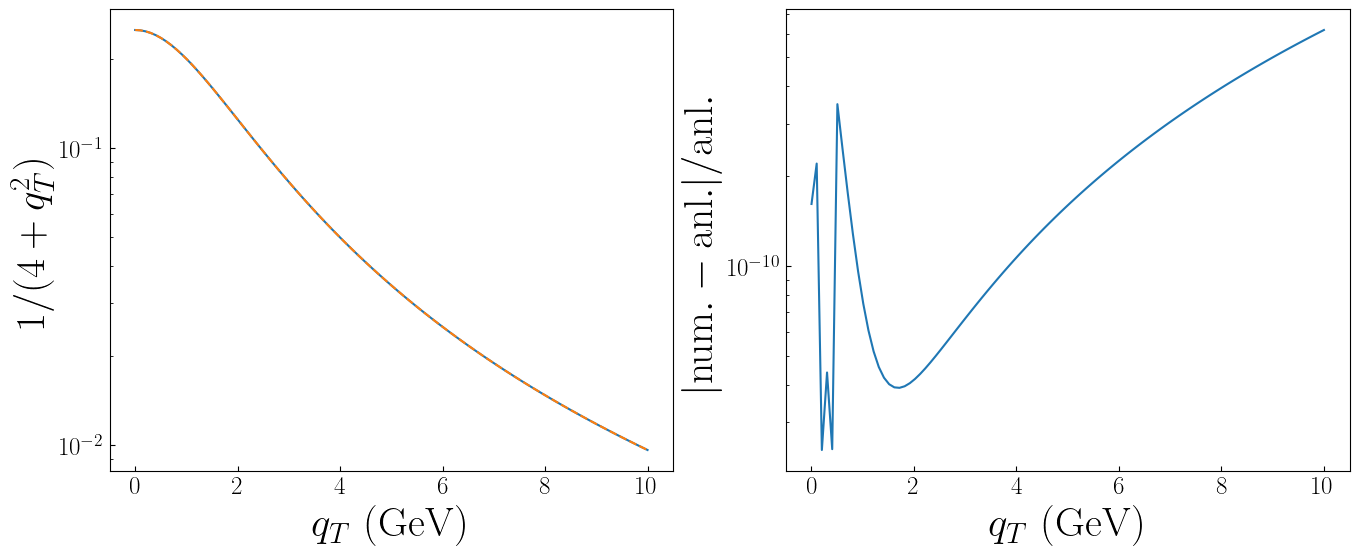

In [32]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,numeric,'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

ax=py.subplot(nrows,ncols,2)
ax.plot(qTs,np.abs(rel_err))
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
ax.semilogy()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

## Try with the TMDs
## $\int_0^\infty db_T b_T J_0(b_T q_T) \tilde{f}(x,Q,b_T) = f(x,Q,k_T)$

In [33]:
def integrand(bT,x,Q,qT):
    # func = kv(0,2*bT)
    fNP = np.exp(-0.2 * bT**2)

    #--up quark
    func = ope.get_OPE_TMDPDF(x,bT)[1] * pertevo.get_exp_Sudakov_perturbative(Q,bT) * fNP
    
    return bT * jv(0,bT * qT) * func

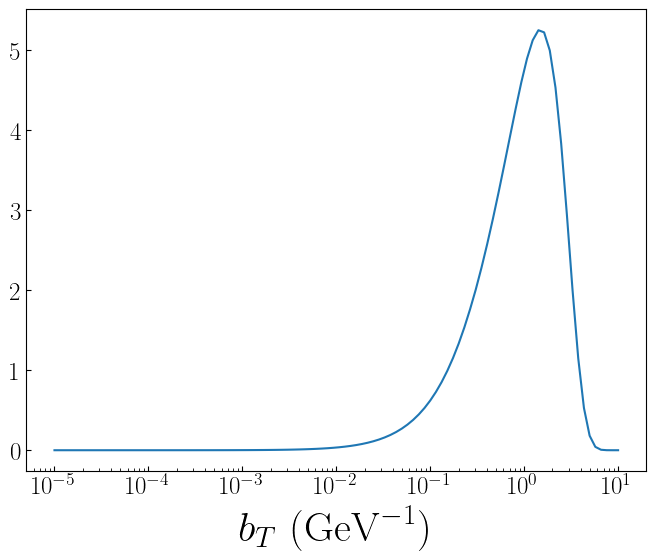

In [34]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,1,100)
x = 0.1
Q = 10
qT = 0.0

intgd = np.array([integrand(_,x,Q,qT) for _ in bTs])
ax.plot(bTs,intgd)
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [35]:
def get_WZ(bTnodes,x,Q,pT,precision=1e-6):

    quad_precision = precision

    bTmax =10

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [ ]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,50)
bmax = 10
x = 0.1
Q = 100
numeric=[]
for i in range(len(qTs)):
    # print(i)
    qt = qTs[i]
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,x,Q,qt,1e-20))
numeric=np.array(numeric)

/scratch/slurm/34112562/.cache/tmp/ipykernel_3648122/1130984758.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
/scratch/slurm/34112562/.cache/tmp/ipykernel_3648122/1130984758.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain

In [ ]:
# rel_err = (numeric - analytic) / analytic

In [ ]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
# ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,np.abs(numeric),'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

# ax=py.subplot(nrows,ncols,2)
# ax.plot(qTs,np.abs(rel_err))
# ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
# ax.semilogy()
# ax.tick_params(direction='in',labelsize=18,which='both',axis='both')